In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

from hep_ml import metrics
from utils import check_correlation
from mass_correlation_utils import *

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Loading
`training.csv` is a mixture of simulated signal, real background.

In [2]:
train_df = pd.read_csv('Data/training.csv.gz', sep=',')

In [3]:
train_df.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


In [4]:
train_df.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'production',
       'signal', 'mass', 'min_ANNmuon'],
      dtype='object')

In [5]:
train_df.shape

(67553, 51)

In [6]:
test_df = pd.read_csv('Data/test.csv.gz', sep=',', index_col='id')

In [7]:
test_df.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits
id,,,,,,,,,,,,,,,,,,,,,
14711831,0.001273,0.999816,8.569642,0.310039,0.197893,5.183939,2.286117,687.479248,0.022301,0.050763,...,508.926514,306.629456,714.222717,30300.734375,5662.158691,7406.368164,4.779700,3.608334,3.029715,705
16316387,0.000661,0.999954,7.061379,0.348772,0.067430,6.316281,3.865824,5691.845703,0.002455,0.037633,...,943.130676,3287.291260,1563.593994,6160.323730,43781.566406,19728.500000,2.563915,3.280884,3.226650,907
6771382,0.000889,0.999999,6.502967,0.273914,0.011020,0.865816,1.004631,5429.225586,0.002753,0.036379,...,2886.055908,2216.936279,598.068359,26387.134766,15534.978516,6504.145020,2.903129,2.634985,3.077517,213
686045,0.001295,0.999301,7.838184,0.325697,0.388636,11.391245,10.345356,661.717834,0.008163,0.436003,...,461.727753,357.967560,1118.084229,5451.857422,10281.403320,23722.742188,3.160085,4.050494,3.747409,275
8755882,0.001714,0.999805,7.064559,0.113440,0.154421,13.925871,12.951378,3885.417969,0.066317,0.052183,...,1773.747925,1643.278198,711.572205,7724.954590,12830.546875,6008.145996,2.151059,2.744157,2.823017,357


In [8]:
test_df.columns

Index(['LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits'],
      dtype='object')

In [9]:
test_df.shape

(855819, 46)

# Baseline Model

In [10]:
train, valid = train_test_split(train_df, test_size=0.3, random_state=13)

Feature selction for training.

In [11]:
variables = list(set(train_df.columns) - {'id', 'signal', 'mass', 'production', 'min_ANNmuon'})
print(variables)

['IP_p1p2', 'p1_IsoBDT', 'p2_pt', 'FlightDistance', 'p0_IP', 'FlightDistanceError', 'iso', 'p2_track_Chi2Dof', 'DOCAone', 'p1_track_Chi2Dof', 'isolationd', 'SPDhits', 'IP', 'IP_p0p2', 'isolationf', 'p1_IP', 'LifeTime', 'CDF2', 'isolationc', 'p1_eta', 'ISO_SumBDT', 'p0_IPSig', 'isolatione', 'p0_pt', 'IPSig', 'CDF1', 'p2_eta', 'p2_IP', 'isolationb', 'p0_eta', 'p0_track_Chi2Dof', 'VertexChi2', 'p1_pt', 'dira', 'p2_IsoBDT', 'p1_p', 'pt', 'p0_p', 'CDF3', 'p2_p', 'p0_IsoBDT', 'p1_IPSig', 'DOCAthree', 'DOCAtwo', 'p2_IPSig', 'isolationa']


In [12]:
# Data Preprocessing

obj_SC = StandardScaler()
obj_SC.fit(train[variables])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
%%time

clf = AdaBoostClassifier(n_estimators=100, 
                         learning_rate=0.01, 
                         random_state=13,
                         base_estimator=DecisionTreeClassifier(max_depth=6, 
                                                               min_samples_leaf=30, 
                                                               max_features=6,
                                                               random_state=13))
clf.fit(obj_SC.transform(train[variables]), train['signal'])

Wall time: 25.2 s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=13, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=13)

## Model Assesment on Validation Set


In [14]:
def plot_metrics(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    plt.plot(fpr, tpr, label='ROC AUC=%f' % roc_auc)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.title("ROC Curve")

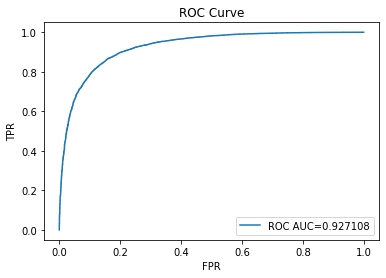

In [15]:
y_pred = clf.predict_proba(obj_SC.transform(valid[variables]))[:, 1]

assert valid.shape[0], y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

In [16]:
valid.shape

(20266, 51)

In [17]:
y_pred.shape

(20266,)

ROC AUC is just a part of the solution, we also have to make sure that

- The classifier output is not correlated with the mass
- Classifier performs similarily on MC and real data of the normalization channel

### 1. Mass Correlation Check

In [18]:
df_corr_check = pd.read_csv("Data/check_correlation.csv.gz")

In [19]:
df_corr_check.shape

(5514, 48)

In [20]:
y_pred = clf.predict(obj_SC.transform(df_corr_check[variables]))

In [21]:
eff = get_efficiencies(y_pred, 
                       df_corr_check.mass, 
                       thresholds = [0.2, 0.4, 0.5, 0.6, 0.8])

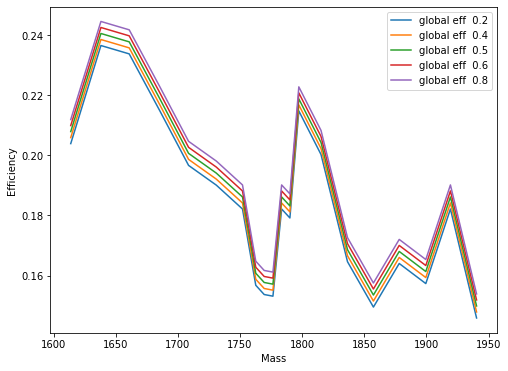

In [22]:
plt.rcParams["figure.figsize"] = 8, 6

up = 1e-3
for label_name, eff_data in eff.items():
    plt.plot(eff_data[0], eff_data[1] + up, label="global eff  %.1f" % label_name)
    up = up + 2e-3

plt.xlabel('Mass')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

In above visualization, y axis is shifted sligthly by 0.002  from previos line just to avoid overlapping.

In [23]:
corr_metric = check_correlation(y_pred, df_corr_check['mass'])
print(corr_metric)

0.0001905337077402401


In [24]:
train[variables][:5]

,IP_p1p2,p1_IsoBDT,p2_pt,FlightDistance,p0_IP,FlightDistanceError,iso,p2_track_Chi2Dof,DOCAone,p1_track_Chi2Dof,...,pt,p0_p,CDF3,p2_p,p0_IsoBDT,p1_IPSig,DOCAthree,DOCAtwo,p2_IPSig,isolationa
56520,0.062145,-0.381186,6216.645996,20.195753,0.637930,0.796748,0.0,0.925666,0.030664,0.982481,...,10099.736328,12295.371094,0.822875,91263.117188,-0.291524,6.057294,0.029572,0.008976,9.325448,0
13514,0.325892,-0.186370,375.047394,5.118261,0.198671,0.417443,3.0,0.725321,0.118355,0.853445,...,2217.499268,15100.987305,0.423252,3798.012939,-0.124454,10.862071,0.053086,0.100980,9.135575,8
35888,0.068194,-0.115879,957.876770,10.196308,0.260135,0.390218,1.0,1.477460,0.009387,1.296389,...,3002.109131,14818.006836,0.278959,30162.423828,-0.187027,22.493523,0.005608,0.018061,4.506374,10
18577,0.214203,-0.115879,627.993042,19.234514,0.158249,1.236785,2.0,0.701390,0.100612,0.772743,...,3172.664795,30549.642578,0.454288,28831.949219,-0.124454,9.493649,0.192668,0.082969,14.288296,0
52205,0.392850,-0.343551,2820.691650,74.620522,1.343604,1.450999,0.0,0.918642,0.035734,1.075603,...,4432.305176,14192.293945,0.635109,99298.960938,-0.397122,28.466829,0.160036,0.162021,8.212289,0


### 2. Performace on Simulated Data (MC) vs Read Data

In [25]:
df_agreement = pd.read_csv('Data/check_agreement.csv.gz')

In [26]:
df_agreement.columns

Index(['id', 'LifeTime', 'dira', 'FlightDistance', 'FlightDistanceError', 'IP',
       'IPSig', 'VertexChi2', 'pt', 'DOCAone', 'DOCAtwo', 'DOCAthree',
       'IP_p0p2', 'IP_p1p2', 'isolationa', 'isolationb', 'isolationc',
       'isolationd', 'isolatione', 'isolationf', 'iso', 'CDF1', 'CDF2', 'CDF3',
       'ISO_SumBDT', 'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT', 'p0_track_Chi2Dof',
       'p1_track_Chi2Dof', 'p2_track_Chi2Dof', 'p0_IP', 'p1_IP', 'p2_IP',
       'p0_IPSig', 'p1_IPSig', 'p2_IPSig', 'p0_pt', 'p1_pt', 'p2_pt', 'p0_p',
       'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta', 'SPDhits', 'signal',
       'weight'],
      dtype='object')

In [27]:
df_agreement[variables].head()

,IP_p1p2,p1_IsoBDT,p2_pt,FlightDistance,p0_IP,FlightDistanceError,iso,p2_track_Chi2Dof,DOCAone,p1_track_Chi2Dof,...,pt,p0_p,CDF3,p2_p,p0_IsoBDT,p1_IPSig,DOCAthree,DOCAtwo,p2_IPSig,isolationa
0,0.214719,-0.089797,834.562378,6.945030,0.483199,0.229196,4.0,1.487057,0.082219,0.862549,...,2251.611816,10392.814453,0.179091,15195.594727,-0.019306,10.732132,0.066887,0.084005,8.853514,8
1,0.217507,-0.186370,2861.309814,9.468235,0.712242,0.517488,3.0,1.336784,0.007983,1.073474,...,10594.470703,3174.356934,0.584701,23134.953125,-0.278330,16.435398,0.001321,0.044154,7.737038,5
2,0.885080,-0.131069,932.128235,13.280714,0.381544,0.219291,1.0,0.798658,0.045085,1.683084,...,2502.196289,15219.761719,0.295038,10180.791016,-0.115879,20.686119,0.005850,0.106614,44.521961,2
3,0.068347,-0.177802,2617.248291,5.166821,0.564650,0.167886,0.0,0.938619,0.055115,1.093031,...,5097.813965,4365.082520,0.533615,24291.875000,-0.208248,7.873435,0.003864,0.038642,9.630725,4
4,0.139937,-0.443564,4763.682617,10.897236,0.373736,0.284975,0.0,1.123868,0.015587,1.471946,...,20388.097656,27463.011719,0.926410,24241.628906,-0.328938,18.738485,0.014612,0.020872,7.389726,0


In [28]:
def splitted_ROC_curve(data_zero, data_one, sample_weights_zero, sample_weights_one):
    """
    Compute Roc Curve
    
    Input:
    - Data_zero: 0-labeled data
    - Data_one:  1-labeled data
    - Sample_weights_zero: weights for 0-labeled data
    - Sample_weights_one:  weights for 1-labeled data
    
    Output: 
    - roc curve
    """
    
    labels = [0] * len(data_zero) + [1] * len(data_one)
    weights = np.concatenate([sample_weights_zero, sample_weights_one])
    data_all = np.concatenate([data_zero, data_one])
    fpr, tpr, _ = roc_curve(labels, data_all, sample_weight=weights)
    return fpr, tpr

In [29]:
def compute_ks(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.
    Input:
    - data_prediction: Real data predictions
    - mc_prediction: Monte Carlo data predictions
    - weights_data: Real data weights
    - weights_mc: Monte Carlo weights
    
    Output
    - ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = np.array(data_prediction), np.array(mc_prediction)
    weights_data, weights_mc = np.array(weights_data), np.array(weights_mc)

    assert np.all(data_prediction >= 0.) and np.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert np.all(mc_prediction >= 0.) and np.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= np.sum(weights_data)
    weights_mc /= np.sum(weights_mc)

    fpr, tpr = splitted_ROC_curve(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = np.max(np.abs(fpr - tpr))
    return Dnm

In [30]:
agreement_probs = clf.predict_proba(obj_SC.transform(df_agreement[variables]))[:, 1]

ks = compute_ks(
                agreement_probs[df_agreement['signal'].values == 0],
                agreement_probs[df_agreement['signal'].values == 1],
                df_agreement[df_agreement['signal'] == 0]['weight'].values,
                df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks)
print("KS Metric value is Fine:", ks < 0.09)

KS metric: 0.15702478939101938
KS Metric value is Fine: False


In [31]:
def plot_ks(X_agreement, y_pred):
    sig_ind = X_agreement[X_agreement['signal'] == 1].index
    bck_ind = X_agreement[X_agreement['signal'] == 0].index

    mc_prob = y_pred[sig_ind]
    mc_weight = np.array(X_agreement.loc[sig_ind]['weight'])
    
    data_prob = y_pred[bck_ind]
    data_weight = np.array(X_agreement.loc[bck_ind]['weight'])
    
    inds = data_weight < 0
    mc_weight = np.array(list(mc_weight) + list(-data_weight[inds]))
    mc_prob = np.array(list(mc_prob) + list(data_prob[inds]))
    
    data_prob = data_prob[data_weight >= 0]
    data_weight = data_weight[data_weight >= 0]
    
    plt.hist(data_prob, weights=data_weight, color='r', histtype='step', density=True, bins=60, label='Data')
    plt.hist(mc_prob, weights=mc_weight, color='b', histtype='step', density=True, bins=60, label='MC')
    
    plt.xlabel("Prediction")
    plt.legend()
    plt.show()

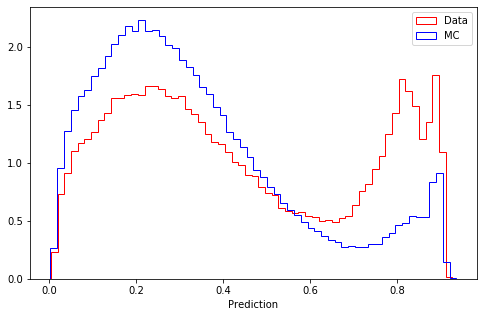

In [32]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs)

We can clearly see that that there is very small agreement between the simualted data and the real data.

## Solution 1: Add Random Noise

To increase the agreement between the real data and simualted data, we can add random noise in predicted probabilities.

In [33]:
def add_noise(array, level=0.40, random_seed=34, noise="uniform"):
    np.random.seed(random_seed)
    if noise == "uniform":
        return level * np.random.uniform(size=array.size) + (1 - level) * array
    elif noise == "gaussian":
        return level * np.random.normal(size=array.size) + (1 - level) * array
    elif noise == "laplacian":
        return level * np.random.laplace(size=array.size) + (1 - level) * array
    elif noise == "laplacian":  
        return level * np.random.standard_t(df=1, size=array.size) + (1 - level) * array

In [34]:
agreement_probs_noise = add_noise(clf.predict_proba(df_agreement[variables])[:, 1])

In [35]:
ks_noise = compute_ks(
                        agreement_probs_noise[df_agreement['signal'].values == 0],
                        agreement_probs_noise[df_agreement['signal'].values == 1],
                        df_agreement[df_agreement['signal'] == 0]['weight'].values,
                        df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks_noise)
print("KS Metric value is Fine:", ks_noise < 0.09)

KS metric: 0.019601326012859077
KS Metric value is Fine: True


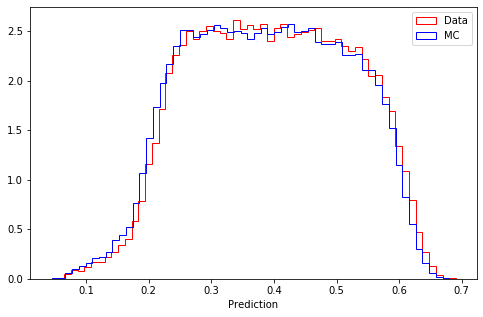

In [36]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs_noise)

### Effect on ROC

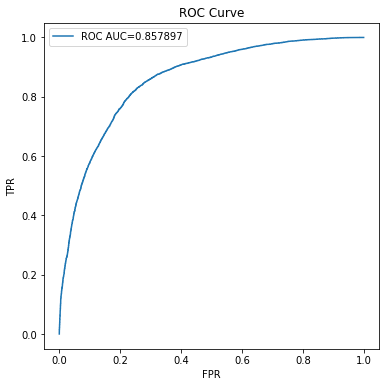

In [37]:
plt.rcParams["figure.figsize"] = 6, 6

y_pred = add_noise(clf.predict_proba(obj_SC.transform(valid[variables]))[:, 1])

assert valid.shape[0] == y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

We have lost the accuracy of the model by adding noise.

# Solution 2: Gradient Boosted Trees with PCA

This approch could help. There is strong correaltion between some covariates and signal varaiable. Principle compionet Analysis helps uncorrelate data.

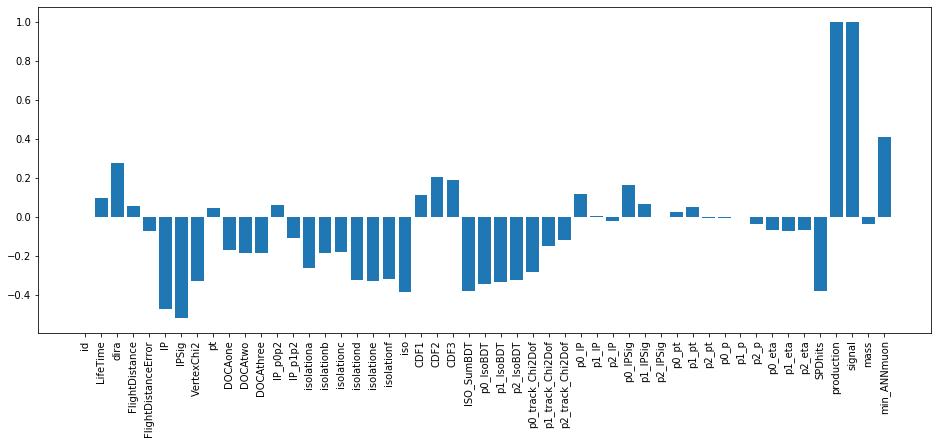

In [38]:
plt.rcParams["figure.figsize"] = 16, 6

plt.bar(train_df.columns, train_df.corr()["signal"])
plt.xticks(rotation='vertical')
plt.show()

Explained Variance Ratio:  0.9999999989738714


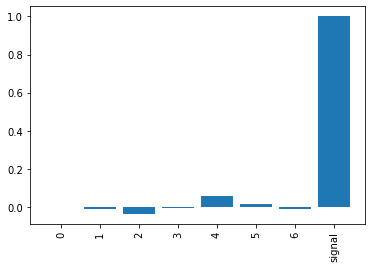

In [39]:
# A PCA model is fitted here just for the visulaization. This will not be used.

plt.rcParams["figure.figsize"] = 6, 4


obj_PCA = PCA(n_components=7, random_state=13)
obj_PCA.fit(train_df)

print("Explained Variance Ratio: ", obj_PCA.explained_variance_ratio_.sum())

temp = pd.DataFrame(obj_PCA.transform(train_df))
temp["signal"] = train_df["signal"]

plt.bar([str(x) for x in temp.columns], temp.corr()["signal"])
plt.xticks(rotation='vertical')
plt.show()

del obj_PCA, temp

We can see here that the correaltion is dropped very much as compared to previous plot. The column names are changes because data is decomposed into the priniple componenet vectors which are projects of components of data in different dimesnions which are mutually normal to each other.

In [40]:
obj_PCA = PCA(n_components=40, random_state=13)
obj_PCA.fit(obj_SC.transform(train[variables]))

print("Explained Variance Ratio: ", obj_PCA.explained_variance_ratio_.sum())

Explained Variance Ratio:  0.996144657944247


In [41]:
%%time

clf_1 = AdaBoostClassifier(n_estimators=100, 
                         learning_rate=0.01, 
                         random_state=13,
                         base_estimator=DecisionTreeClassifier(max_depth=6, 
                                                               min_samples_leaf=30, 
                                                               max_features=6,
                                                               random_state=13))

clf_1.fit(obj_PCA.transform(obj_SC.transform(train[variables])), train['signal'])

Wall time: 29.5 s


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=13, splitter='best'),
          learning_rate=0.01, n_estimators=100, random_state=13)

In [42]:
agreement_probs_pca = clf_1.predict_proba(obj_PCA.transform(obj_SC.transform(df_agreement[variables])))[:, 1]

In [43]:
ks_noise = compute_ks(
                        agreement_probs_pca[df_agreement['signal'].values == 0],
                        agreement_probs_pca[df_agreement['signal'].values == 1],
                        df_agreement[df_agreement['signal'] == 0]['weight'].values,
                        df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks_noise)
print("KS Metric value is Fine:", ks_noise < 0.09)

KS metric: 0.09637934904176032
KS Metric value is Fine: False


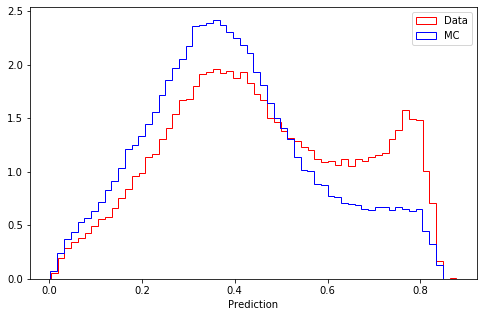

In [44]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs_pca)

The agreemnt between the simualted data and the real data improved as compared to the baseline model.

### Effect on ROC

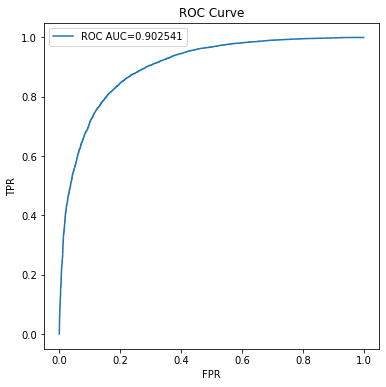

In [45]:
plt.rcParams["figure.figsize"] = 6, 6

y_pred = clf_1.predict_proba(obj_PCA.transform(obj_SC.transform(valid[variables])))[:, 1]

assert valid.shape[0] == y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

Also I am able to retain the AUC metric wuth decrese from 92.xxxx to 90.xxxx

# Solution 3: Neural Networks with Missing Mass Reconstruction

In [46]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [47]:
from keras import backend as K

def r_sqaured_error(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [48]:
def NN(input_dim, weight=[1.0, 1.0]):
    shared = Sequential()
    shared.add(Dense(100, activation="relu", name="Hidden_1"))
    shared.add(Dense(80, activation="relu", name="Hidden_2"))
    shared.add(Dense(60, activation="relu", name="Hidden_3"))


    data = Input(shape=(input_dim, ), name="Input_Layer")
    features = shared(data)

    signal = Dense(1, activation='sigmoid', name='Signal', kernel_initializer="glorot_normal")(features)
    mass   = Dense(1, activation='linear', name='Mass', kernel_initializer="glorot_normal")(features)

    model =  Model(inputs=[data], outputs=[signal, mass])
    model.compile(optimizer = 'Adam', 
                  loss = ['binary_crossentropy', "mean_squared_error"],
                  loss_weights = weight)
    
    return model

In [49]:
model = NN(len(variables), weight=[1, .5])
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [50]:
obj_SC_mass = StandardScaler()
obj_SC_mass.fit(train["mass"].values.reshape(-1, 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [51]:
model.fit(x = [obj_SC.transform(train[variables])], 
          y = [train["signal"], obj_SC_mass.transform([train["mass"]])[0]],
          batch_size = 5000, 
          epochs = 100,
          validation_split = 0.1)

Train on 42558 samples, validate on 4729 samples
Epoch 1/100
42558/42558 [==============================] - 1s 17us/step - loss: 1.1795 - Signal_loss: 0.6279 - Mass_loss: 1.1033 - val_loss: 1.0697 - val_Signal_loss: 0.5561 - val_Mass_loss: 1.0272
Epoch 2/100
42558/42558 [==============================] - 0s 6us/step - loss: 1.0267 - Signal_loss: 0.5124 - Mass_loss: 1.0285 - val_loss: 0.9659 - val_Signal_loss: 0.4578 - val_Mass_loss: 1.0163
Epoch 3/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.9338 - Signal_loss: 0.4273 - Mass_loss: 1.0130 - val_loss: 0.9041 - val_Signal_loss: 0.4034 - val_Mass_loss: 1.0014
Epoch 4/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.8834 - Signal_loss: 0.3815 - Mass_loss: 1.0038 - val_loss: 0.8661 - val_Signal_loss: 0.3676 - val_Mass_loss: 0.9971
Epoch 5/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.8483 - Signal_loss: 0.3511 - Mass_loss: 0.9944 - val_loss: 0.8410 - val_Signal_lo

Epoch 42/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.5826 - Signal_loss: 0.2525 - Mass_loss: 0.6602 - val_loss: 0.6703 - val_Signal_loss: 0.2762 - val_Mass_loss: 0.7882
Epoch 43/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.5771 - Signal_loss: 0.2522 - Mass_loss: 0.6498 - val_loss: 0.6616 - val_Signal_loss: 0.2762 - val_Mass_loss: 0.7707
Epoch 44/100
42558/42558 [==============================] - 0s 5us/step - loss: 0.5702 - Signal_loss: 0.2517 - Mass_loss: 0.6372 - val_loss: 0.6616 - val_Signal_loss: 0.2753 - val_Mass_loss: 0.7726
Epoch 45/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.5645 - Signal_loss: 0.2515 - Mass_loss: 0.6260 - val_loss: 0.6582 - val_Signal_loss: 0.2762 - val_Mass_loss: 0.7641
Epoch 46/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.5605 - Signal_loss: 0.2512 - Mass_loss: 0.6185 - val_loss: 0.6554 - val_Signal_loss: 0.2761 - val_Mass_loss: 0.7587
Epoch 47/1

42558/42558 [==============================] - 0s 5us/step - loss: 0.4415 - Signal_loss: 0.2396 - Mass_loss: 0.4037 - val_loss: 0.5902 - val_Signal_loss: 0.2768 - val_Mass_loss: 0.6269
Epoch 84/100
42558/42558 [==============================] - 0s 5us/step - loss: 0.4403 - Signal_loss: 0.2393 - Mass_loss: 0.4021 - val_loss: 0.5927 - val_Signal_loss: 0.2768 - val_Mass_loss: 0.6317
Epoch 85/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.4403 - Signal_loss: 0.2394 - Mass_loss: 0.4017 - val_loss: 0.5902 - val_Signal_loss: 0.2778 - val_Mass_loss: 0.6247
Epoch 86/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.4392 - Signal_loss: 0.2391 - Mass_loss: 0.4000 - val_loss: 0.5841 - val_Signal_loss: 0.2773 - val_Mass_loss: 0.6137
Epoch 87/100
42558/42558 [==============================] - 0s 6us/step - loss: 0.4366 - Signal_loss: 0.2388 - Mass_loss: 0.3955 - val_loss: 0.5912 - val_Signal_loss: 0.2769 - val_Mass_loss: 0.6285
Epoch 88/100
42558/4255

In [52]:
def get_prob(model, df):
    prediction, _ =  model.predict(obj_SC.transform(df[variables]))
    return prediction

In [53]:
agreement_probs_mass = get_prob(model, df_agreement)

In [54]:
ks_noise = compute_ks(
                        agreement_probs_mass[df_agreement['signal'].values == 0],
                        agreement_probs_mass[df_agreement['signal'].values == 1],
                        df_agreement[df_agreement['signal'] == 0]['weight'].values,
                        df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks_noise)
print("KS Metric value is Fine:", ks_noise < 0.09)

KS metric: 0.2385587717259121
KS Metric value is Fine: False


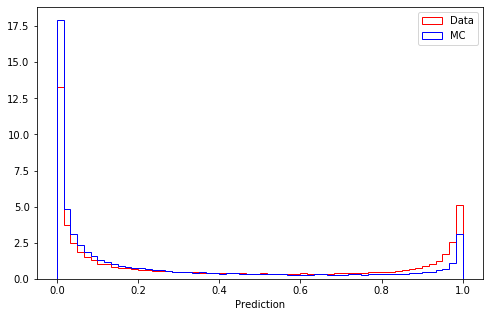

In [55]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs_mass)

### Effect on ROC

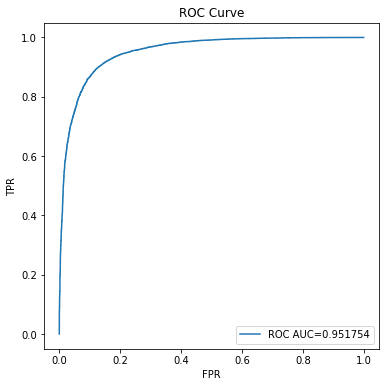

In [56]:
plt.rcParams["figure.figsize"] = 6, 6

y_pred = get_prob(model, valid)

assert valid.shape[0] == y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

# Solution 4: Neural Networks with Missing Variables Reconstruction

The neural network will be trained to predict the $signal$ varialbe while varialbes like $mass$, $min_ANNmuon$, and $production$ will be regressed as auxillary ends to reinforce the training of signal classifier. This is similar as previos case but instead more maraibles are used in addition to mass.

In [65]:
def NN_upgrade(input_dim, weight=[1.0, 1.0, 1.0, 1.0]):
    shared = Sequential()
    shared.add(Dense(100, activation="relu", name="Hidden_1"))
    shared.add(Dense(80, activation="relu", name="Hidden_2"))
    shared.add(Dense(60, activation="relu", name="Hidden_3"))


    data = Input(shape=(input_dim, ), name="Input_Layer")
    features = shared(data)

    signal = Dense(1, activation='sigmoid', name='Signal', kernel_initializer="glorot_normal")(features)
    mass   = Dense(1, activation='linear', name='Mass', kernel_initializer="glorot_normal")(features)
    min_ANNmuon = Dense(1, activation='sigmoid', name='min_ANNmuon', kernel_initializer="glorot_normal")(features)
    production = Dense(1, activation='sigmoid', name='Production', kernel_initializer="glorot_normal")(features)
    

    model =  Model(inputs=[data], outputs=[signal, mass, min_ANNmuon, production])
    model.compile(optimizer = 'Adam', 
                  loss = ['binary_crossentropy', "mean_squared_error", "binary_crossentropy", "binary_crossentropy"],
                  loss_weights = weight)
    
    return model

In [66]:
model_1 = NN_upgrade(len(variables), weight=[1, 0.5, 1, 1])
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [67]:
model_1.fit(x = [obj_SC.transform(train[variables])], 
          y = [
                  train["signal"], 
                  obj_SC_mass.transform([train["mass"]])[0], 
                  train["min_ANNmuon"], 
                  train["production"] > 0
              ],
          batch_size = 5000, 
          epochs = 100,
          validation_split = 0.1)

Train on 42558 samples, validate on 4729 samples
Epoch 1/100
42558/42558 [==============================] - 1s 29us/step - loss: 2.6077 - Signal_loss: 0.7211 - Mass_loss: 1.0516 - min_ANNmuon_loss: 0.7123 - Production_loss: 0.6486 - val_loss: 2.3910 - val_Signal_loss: 0.6215 - val_Mass_loss: 1.0036 - val_min_ANNmuon_loss: 0.6828 - val_Production_loss: 0.5849
Epoch 2/100
42558/42558 [==============================] - 0s 7us/step - loss: 2.3117 - Signal_loss: 0.5766 - Mass_loss: 1.0241 - min_ANNmuon_loss: 0.6825 - Production_loss: 0.5406 - val_loss: 2.1787 - val_Signal_loss: 0.5134 - val_Mass_loss: 0.9951 - val_min_ANNmuon_loss: 0.6844 - val_Production_loss: 0.4834
Epoch 3/100
42558/42558 [==============================] - 0s 7us/step - loss: 2.1105 - Signal_loss: 0.4721 - Mass_loss: 1.0132 - min_ANNmuon_loss: 0.6796 - Production_loss: 0.4522 - val_loss: 2.0238 - val_Signal_loss: 0.4297 - val_Mass_loss: 0.9879 - val_min_ANNmuon_loss: 0.6767 - val_Production_loss: 0.4235
Epoch 4/100
42558

42558/42558 [==============================] - 0s 6us/step - loss: 1.6096 - Signal_loss: 0.2529 - Mass_loss: 0.8910 - min_ANNmuon_loss: 0.6581 - Production_loss: 0.2532 - val_loss: 1.6775 - val_Signal_loss: 0.2763 - val_Mass_loss: 0.9362 - val_min_ANNmuon_loss: 0.6584 - val_Production_loss: 0.2747
Epoch 28/100
42558/42558 [==============================] - 0s 6us/step - loss: 1.6030 - Signal_loss: 0.2514 - Mass_loss: 0.8833 - min_ANNmuon_loss: 0.6581 - Production_loss: 0.2518 - val_loss: 1.6715 - val_Signal_loss: 0.2755 - val_Mass_loss: 0.9257 - val_min_ANNmuon_loss: 0.6590 - val_Production_loss: 0.2742
Epoch 29/100
42558/42558 [==============================] - 0s 6us/step - loss: 1.5963 - Signal_loss: 0.2501 - Mass_loss: 0.8755 - min_ANNmuon_loss: 0.6581 - Production_loss: 0.2504 - val_loss: 1.6676 - val_Signal_loss: 0.2756 - val_Mass_loss: 0.9199 - val_min_ANNmuon_loss: 0.6583 - val_Production_loss: 0.2738
Epoch 30/100
42558/42558 [==============================] - 0s 6us/step - los

42558/42558 [==============================] - 0s 9us/step - loss: 1.4634 - Signal_loss: 0.2322 - Mass_loss: 0.6838 - min_ANNmuon_loss: 0.6572 - Production_loss: 0.2321 - val_loss: 1.6129 - val_Signal_loss: 0.2724 - val_Mass_loss: 0.8204 - val_min_ANNmuon_loss: 0.6589 - val_Production_loss: 0.2714
Epoch 54/100
42558/42558 [==============================] - 0s 7us/step - loss: 1.4620 - Signal_loss: 0.2314 - Mass_loss: 0.6843 - min_ANNmuon_loss: 0.6571 - Production_loss: 0.2313 - val_loss: 1.6108 - val_Signal_loss: 0.2739 - val_Mass_loss: 0.8114 - val_min_ANNmuon_loss: 0.6585 - val_Production_loss: 0.2727
Epoch 55/100
42558/42558 [==============================] - 0s 7us/step - loss: 1.4545 - Signal_loss: 0.2306 - Mass_loss: 0.6725 - min_ANNmuon_loss: 0.6571 - Production_loss: 0.2306 - val_loss: 1.6096 - val_Signal_loss: 0.2730 - val_Mass_loss: 0.8124 - val_min_ANNmuon_loss: 0.6585 - val_Production_loss: 0.2720
Epoch 56/100
42558/42558 [==============================] - 0s 7us/step - los

42558/42558 [==============================] - 0s 7us/step - loss: 1.3547 - Signal_loss: 0.2168 - Mass_loss: 0.5294 - min_ANNmuon_loss: 0.6566 - Production_loss: 0.2166 - val_loss: 1.5780 - val_Signal_loss: 0.2783 - val_Mass_loss: 0.7252 - val_min_ANNmuon_loss: 0.6584 - val_Production_loss: 0.2787
Epoch 80/100
42558/42558 [==============================] - 0s 7us/step - loss: 1.3515 - Signal_loss: 0.2158 - Mass_loss: 0.5270 - min_ANNmuon_loss: 0.6566 - Production_loss: 0.2156 - val_loss: 1.5792 - val_Signal_loss: 0.2792 - val_Mass_loss: 0.7247 - val_min_ANNmuon_loss: 0.6582 - val_Production_loss: 0.2795
Epoch 81/100
42558/42558 [==============================] - 0s 7us/step - loss: 1.3465 - Signal_loss: 0.2154 - Mass_loss: 0.5185 - min_ANNmuon_loss: 0.6566 - Production_loss: 0.2153 - val_loss: 1.5813 - val_Signal_loss: 0.2792 - val_Mass_loss: 0.7286 - val_min_ANNmuon_loss: 0.6582 - val_Production_loss: 0.2797
Epoch 82/100
42558/42558 [==============================] - 0s 7us/step - los

In [68]:
def get_prob(model, df):
    prediction, _, _, _ =  model.predict(obj_SC.transform(df[variables]))
    return prediction

In [69]:
agreement_probs_vars = get_prob(model_1, df_agreement)

In [70]:
ks_noise = compute_ks(
                        agreement_probs_vars[df_agreement['signal'].values == 0],
                        agreement_probs_vars[df_agreement['signal'].values == 1],
                        df_agreement[df_agreement['signal'] == 0]['weight'].values,
                        df_agreement[df_agreement['signal'] == 1]['weight'].values)

print ('KS metric:', ks_noise)
print("KS Metric value is Fine:", ks_noise < 0.09)

KS metric: 0.24865331084019127
KS Metric value is Fine: False


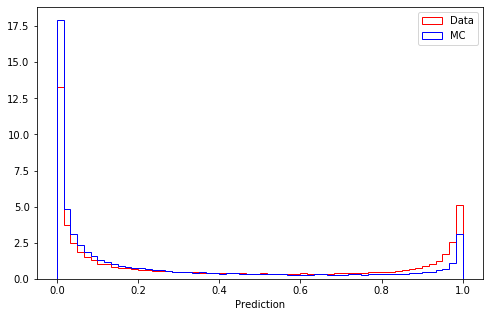

In [71]:
plt.rcParams["figure.figsize"] = 8, 5

plot_ks(df_agreement, agreement_probs_mass)

### Effect on ROC

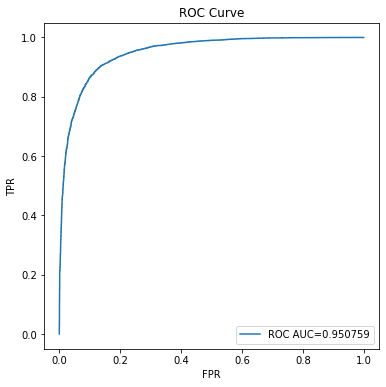

In [72]:
plt.rcParams["figure.figsize"] = 6, 6

y_pred = get_prob(model_1, valid)

assert valid.shape[0] == y_pred.shape[0]

plot_metrics(valid['signal'], y_pred)

Due to addition of other variabel addition, the sparsity in gradient has decresed at very small level which is not significant, but there is not so specific impact on the AUC metric.

# Data Doping with Neural Networks